In [3]:
#imports essentiels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

#Téléchargement sélectif des ressources NLTK (plus efficace)
nltk_downloads = ['stopwords', 'wordnet','punkt','averaged_perceptron_tagger']
for resource in nltk_downloads:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource, quiet=True)
# configuration matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

[nltk_data]    |   Package pil is already up-to-date!
[nltk_data]    | Downloading package pl196x to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package pl196x is already up-to-date!
[nltk_data]    | Downloading package ppattach to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package ppattach is already up-to-date!
[nltk_data]    | Downloading package problem_reports to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package problem_reports is already up-to-date!
[nltk_data]    | Downloading package propbank to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package propbank is already up-to-date!
[nltk_data]    | Downloading package ptb to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]  

[nltk_data]    |   Package punkt is already up-to-date!
[nltk_data]    | Downloading package book_grammars to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package book_grammars is already up-to-date!
[nltk_data]    | Downloading package sample_grammars to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package sample_grammars is already up-to-date!
[nltk_data]    | Downloading package spanish_grammars to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package spanish_grammars is already up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\agar.blohorn\AppData\Roaming\nltk_data..
[nltk_data]    |     .
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package large_grammars to
[nltk_data]    |     C:\Use

# Classification automatique des biens de consommations

## Objectif du TP

Développer un système d'analyse de données textuelles pour classifier automatiquement des produits e-commerce en différentes catégories, en utilisant les techniques de traitement du langage naturel (NLP).

## Contexte

Vous travaillez pour une marketplace qui souhaite automatiser la classification de ses produits. Votre mission est d'analyser les descriptions textuelles des produits pour comprendre les patterns et préparer les données pour un futur système de classification automatique.

## Dataset

Le jeu de données provient de Flipkart (marketplace indienne) et contient 1050 produits avec leurs descriptions et caractéristiques.

---


## Fonction utilitaires

In [11]:
def load_and_validate(filepath):
    """
    Charge et valide le jeu de données
    """
    try :
        df = pd.read_csv(filepath)
        print(f"Données chargées avec succès : {df.shape[0]} lignes, {df.shape[1]} colonnes")
        return df
    except FileNotFoundError:
        print(f"Fichier non trouvé:{filepath}")
        return None
    except Exception as e:
        print(f"Erreur lors du chargement : {e}")
        return None


In [4]:
im = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

Flipkart est une entreprise indienne de commerce en ligne basée à Bangalore.

## Analyse du jeu de donnée

In [5]:
im.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...

In [6]:
l = im.shape
vm = im.isnull().sum().sum()/len(im)*100

In [7]:
print("le jeu de donnée est composé de",l[0] ,"produits et de",l[1], "variables caractéristiques")

le jeu de donnée est composé de 1050 produits et de 15 variables caractéristiques


In [8]:
data = np.array([(l[0],l[1],vm)])
tableau = pd.DataFrame(data , columns = ['Nombre de lignes','Nombre de colonnes','% de valeurs manquantes'])

In [9]:
tableau

Nombre de lignes  Nombre de colonnes  % de valeurs manquantes
0            1050.0                15.0                 32.47619

In [10]:
im.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [11]:
im.isnull().sum()/len(im)*100

uniq_id                     0.000000
crawl_timestamp             0.000000
product_url                 0.000000
product_name                0.000000
product_category_tree       0.000000
pid                         0.000000
retail_price                0.095238
discounted_price            0.095238
image                       0.000000
is_FK_Advantage_product     0.000000
description                 0.000000
product_rating              0.000000
overall_rating              0.000000
brand                      32.190476
product_specifications      0.095238
dtype: float64

La seule variable contenant des valeurs manquantes est la colonnes 'brand':Marque

In [12]:
im.describe()

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

<AxesSubplot:ylabel='retail_price'>

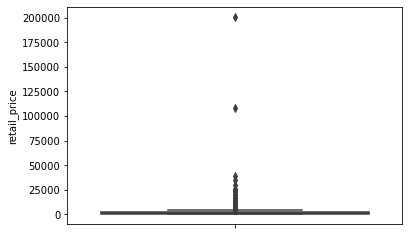

In [13]:
sns.boxplot(y = 'retail_price', data=im)

(0.0, 40000.0)

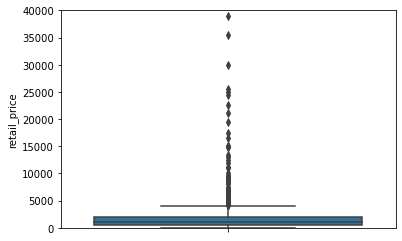

In [14]:
sns.boxplot(y = 'retail_price', data=im)
plt.ylim(0,40000)

Text(0.5, 1.0, 'Répartition des produits en fonction de leur marque')

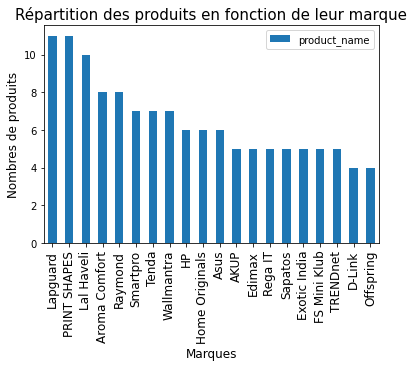

In [15]:
im.groupby("brand").agg({'product_name':'count'}).sort_values(by='product_name', ascending = False)[:20].plot(kind = 'bar')
plt.xticks(fontsize = 12)
plt.xlabel('Marques' , fontsize = 12)
plt.ylabel('Nombres de produits', fontsize = 12)
plt.title("Répartition des produits en fonction de leur marque", fontsize = 15)

Text(0.5, 1.0, 'Moyenne des prix des produits par marques')

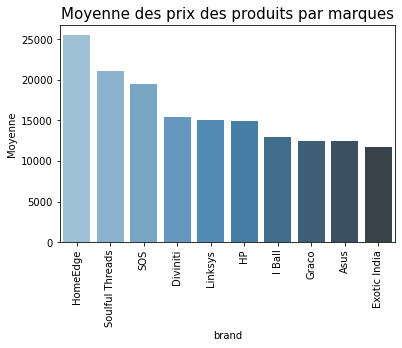

In [16]:
l = im.groupby('brand').agg({'retail_price':'mean'}).sort_values(by = 'retail_price', ascending = False)[:10].reset_index()
sns.barplot(x="brand", y="retail_price", data=l,
                 palette="Blues_d")
plt.xlabel('brand', fontsize = 10)
plt.ylabel('Moyenne', fontsize = 10)
plt.xticks(fontsize=10,rotation=90)
plt.title('Moyenne des prix des produits par marques', fontsize = 15)

- **HomeEdge** : Mobilier maison 
- **Soulful Threads** : vetements
- **SOS** : Chaussures
- **Divinti** : Bijoux
- **Exotic India** : décoration indienne

## Analyse des données textuelles

### Extraction des catégories des produits  

In [17]:
im["product_category_tree"][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [18]:
T = im['product_category_tree'].str.split('>>',expand=True)
T

0                         1                   2  \
0     ["Home Furnishing    Curtains & Accessories            Curtains    
1           ["Baby Care          Baby Bath & Skin    Baby Bath Towels    
2           ["Baby Care          Baby Bath & Skin    Baby Bath Towels    
3     ["Home Furnishing                 Bed Linen           Bedsheets    
4     ["Home Furnishing                 Bed Linen           Bedsheets    
...                  ...                       ...                 ...   
1045        ["Baby Care         Baby & Kids Gifts            Stickers    
1046        ["Baby Care         Baby & Kids Gifts            Stickers    
1047        ["Baby Care         Baby & Kids Gifts            Stickers    
1048        ["Baby Care         Baby & Kids Gifts            Stickers    
1049        ["Baby Care         Baby & Kids Gifts            Stickers    

                                                      3  \
0      Elegance Polyester Multicolor Abstract Eyelet...   
1                            Sathiyas Baby Bath Towels    
2                             Eurospa Baby Bath Towels    
3                      SANTOSH ROYAL FASHION Bedsheets    
4                               Jaipur Print Bedsheets    
...                                                 ...   
1045                            Oren Empower Stickers"]   
1046                              Wallmantra Stickers"]   
1047                                Uberlyfe Stickers"]   
1048                              Wallmantra Stickers"]   
1049                                Uberlyfe Stickers"]   

                                                      4     5     6  
0                                                  None  None  None  
1      Sathiyas Cotton Bath Towel (3 Bath Towel, Red...  None  None  
2      Eurospa Cotton Terry Face Towel Set (20 PIECE...  None  None  
3      SANTOSH ROYAL FASHION Cotton Printed King siz...  None  None  
4      Jaipur Print Cotton Floral King sized Double ...  None  None  
...                                                 ...   ...   ...  
1045                                               None  None  None  
1046                                               None  None  None  
1047                                               None  None  None  
1048                                               None  None  None  
1049                                               None  None  None  

[1050 rows x 7 columns]

In [19]:
T[0] = T[0].str.replace(r'[^a-zA-Z]','')

In [20]:
im['target'] = T[0]

### Nettoyage de la colonne description des produits 

#### Preprocessing avec la méthode stemming

In [21]:
words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [22]:
im['description_cleaned'] = im['description'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]"," ",x).split() if i not in words]).lower())

In [23]:
im[['description', 'description_cleaned','target']]

description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                    description_cleaned          target  
0     key featur eleg polyest multicolor abstract ey...  HomeFurnishing  
1     specif sathiya cotton bath towel bath towel re...        BabyCare  
2     key featur eurospa cotton terri face towel set...        BabyCare  
3     key featur santosh royal fashion cotton print ...  HomeFurnishing  
4     key featur jaipur print cotton floral king siz...  HomeFurnishing  
...                                                 ...             ...  
1045  oren empow extra larg self adhes sticker pack ...        BabyCare  
1046  wallmantra larg vinyl sticker sticker pack pri...        BabyCare  
1047  buy uberlyf extra larg pigment polyvinyl film ...        BabyCare  
1048  buy wallmantra medium vinyl sticker sticker rs...        BabyCare  
1049  buy uberlyf larg vinyl sticker rs onlin uberly...        BabyCare  

[1050 rows x 3 columns]

HomeFurnishing           150
KitchenDining            150
Computers                150
Watches                  150
BabyCare                 150
BeautyandPersonalCare    150
HomeDecorFestiveNeeds    150
Name: target, dtype: int64


C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'repartition du nombre de produits par catégories')

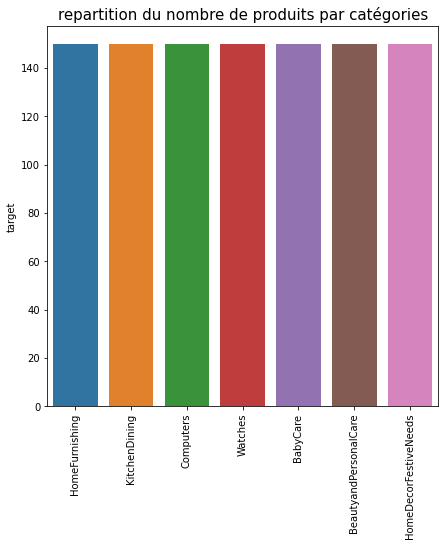

In [24]:
c=im['target'].value_counts()
print(c)
plt.figure(figsize=(7,7))
sns.barplot(c.index,c)
plt.xticks(rotation=90)
plt.title("repartition du nombre de produits par catégories", fontsize = 15)

**Le nombre de produits par catégorie sont identiques, on a des classes équilibrées**

In [25]:
# WORD-COUNT
im['word_count'] = im['description_cleaned'].apply(lambda x: len(str(x).split()))

print('la moyenne des mots du texte descriptifs pour les produits BeautyandPersonalCare est: ')
print(im[im['target']=='BeautyandPersonalCare']['word_count'].mean()) 

print('la moyenne des mots du texte descriptifs pour les produits Computers est: ')
print(im[im['target']=="Computers"]['word_count'].mean())

print('la moyenne des mots du texte descriptifs pour les produits BabyCare est: ')
print(im[im['target']=='BabyCare']['word_count'].mean()) 

print('la moyenne des mots du texte descriptifs pour les produits Watches est: ')
print(im[im['target']=="Watches"]['word_count'].mean())

print('la moyenne des mots du texte descriptifs pour les produits KitchenDining est: ')
print(im[im['target']=='KitchenDining']['word_count'].mean()) 

print('la moyenne des mots du texte descriptifs pour les produits HomeFurnishing est: ')
print(im[im['target']=="HomeFurnishing"]['word_count'].mean())

print('la moyenne des mots du texte descriptifs pour les produits HomeDecorFestiveNeeds est: ')
print(im[im['target']=="HomeDecorFestiveNeeds"]['word_count'].mean())

la moyenne des mots du texte descriptifs pour les produits BeautyandPersonalCare est: 
46.62
la moyenne des mots du texte descriptifs pour les produits Computers est: 
68.91333333333333
la moyenne des mots du texte descriptifs pour les produits BabyCare est: 
64.13333333333334
la moyenne des mots du texte descriptifs pour les produits Watches est: 
43.36666666666667
la moyenne des mots du texte descriptifs pour les produits KitchenDining est: 
75.22666666666667
la moyenne des mots du texte descriptifs pour les produits HomeFurnishing est: 
47.36
la moyenne des mots du texte descriptifs pour les produits HomeDecorFestiveNeeds est: 
67.2


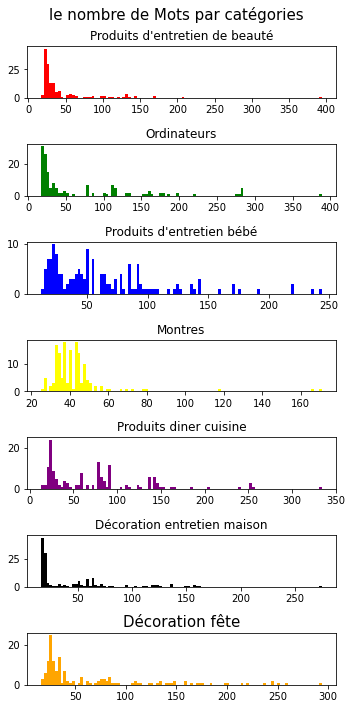

In [26]:
fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7)=plt.subplots(7,1,figsize=(5,10))
BPC=im[im['target']=='BeautyandPersonalCare']['word_count']
ax1.hist(BPC,bins = 100,color='red')
ax1.set_title('Produits d\'entretien de beauté')
C=im[im['target']=="Computers"]['word_count']
ax2.hist(C,bins = 100,color='green')
ax2.set_title('Ordinateurs')
BC=im[im['target']=='BabyCare']['word_count']
ax3.hist(BC,bins=100,color='blue')
ax3.set_title('Produits d\'entretien bébé')
W=im[im['target']=="Watches"]['word_count']
ax4.hist(W,bins=100,color='yellow')
ax4.set_title('Montres')
K=im[im['target']=="KitchenDining"]['word_count']
ax5.hist(K,bins=100,color='purple')
ax5.set_title('Produits diner cuisine')
HF=im[im['target']=='HomeFurnishing']['word_count']
ax6.hist(HF,bins=100,color='black')
ax6.set_title('Décoration entretien maison')
HDF=im[im['target']=="HomeDecorFestiveNeeds"]['word_count']
ax7.hist(HDF,bins=100,color='orange')
ax7.set_title('Décoration fête', fontsize= 15)
fig.suptitle('le nombre de Mots par catégories', fontsize= 15)
fig.tight_layout()
plt.show()

In [27]:
NUM_TOP_WORDS = 50
top_10_0 = hero.visualization.top_words(im['description']).head(NUM_TOP_WORDS)
top_10_0

of              1660
and             1167
the             1015
to               982
-                926
for              836
in               753
Only             717
at               701
with             688
For              603
your             600
Rs               592
Products         577
is               576
Buy              566
Genuine          564
a                558
Replacement      520
cm               510
&                492
30               490
Day              478
Flipkart.com     472
Guarantee        469
On               425
1                425
on               406
Free             406
Delivery         382
Cash             381
Shipping         381
from             352
The              346
Price            344
Features         337
Watch            303
Pack             303
Type             298
In               287
Baby             287
General          285
Package          268
Box              265
Sales            261
you              261
Set              258
this         

In [28]:
NUM_TOP_WORDS = 10
top_10 = hero.visualization.top_words(im['description_cleaned']).head(NUM_TOP_WORDS)
top_10 = pd.DataFrame(data = [(911,870,718,618,611,581,570,569,567,564)], 
                      columns = ['roupies','product','online','free','for','buy','replacement','shipping','delivery','genuine'])
top_10

roupies  product  online  free  for  buy  replacement  shipping  delivery  \
0      911      870     718   618  611  581          570       569       567   

   genuine  
0      564

**rs : roupies** les 10 mots les plus importants sont les mots que l'on retrouvent essentiellement pour toutes les catégories comme le prix, les conditions de livraison, l'achat, les retours...

Text(0.5, 1.0, 'les 10 mots les plus fréquents dans le corpus')

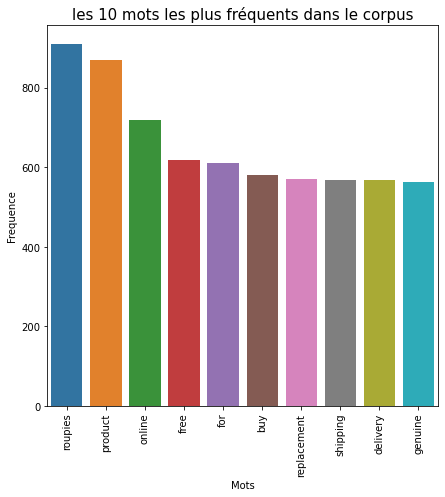

In [29]:
plt.figure(figsize=(7,7))
sns.barplot(data = top_10)
plt.xticks(rotation=90)
plt.xlabel('Mots')
plt.ylabel('Frequence')
plt.title('les 10 mots les plus fréquents dans le corpus', fontsize = 15)

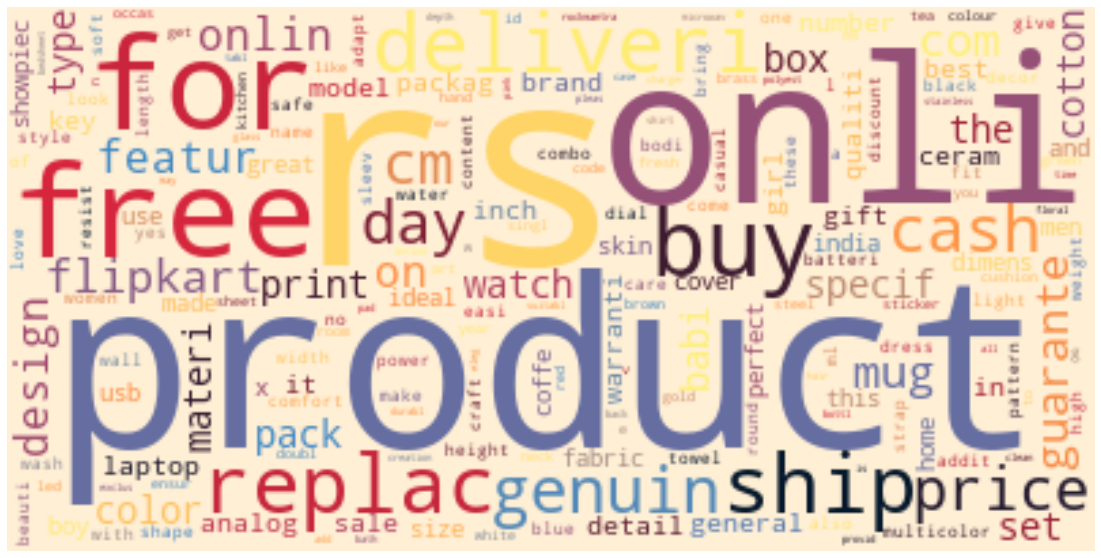

In [30]:
hero.visualization.wordcloud(im['description_cleaned'])

In [31]:
flop_10_0 = hero.visualization.top_words(im['description']).tail(50)
flop_10_0

Amber              1
arch               1
Sciences           1
Maintenance        1
gaither            1
Rs.2750            1
wants              1
absolute           1
pottery            1
Admired            1
Detangling         1
715                1
amnesia            1
Machine-wash       1
mee                1
Humidity           1
MUSCLE             1
Rs.201000          1
V-shaped           1
Ta                 1
88TBTSH0385        1
app(iOS,Android    1
shades             1
Mukut              1
MohanJodero        1
Rs.250             1
pleasing           1
flavoured          1
shadow             1
job                1
Research           1
Lxs-001            1
teas               1
IC                 1
WILL               1
Accidental         1
72x78              1
60c                1
Marketing          1
Washable,Amit      1
Ages               1
minutes            1
Hd                 1
Spectrum           1
998                1
Shears             1
Valentine's        1
11oz         

In [46]:
flop_10 = hero.visualization.top_words(im['description_cleaned']).tail(NUM_TOP_WORDS)
flop_10

oshea       1
sscp        1
regard      1
crack       1
hip         1
persnal     1
agarwood    1
market      1
mail        1
appar       1
Name: description_cleaned, dtype: int64

**Ajout d'une colonne 'decription_cleaned_bis' avec l'ajout des stopwords, des mots qui sont présents dans toutes les catégories**

In [50]:
#Créer sa propre liste de stopword, les mots qui sont communs a toutes les catégories 
words = stopwords.words('english')
mystopword = ['Rs','Product','Buy','Products','Free','Flipkart','Features','Delivery','Shipping','Cash','Day','Genuine','Price','Prices','Package']
words.extend(mystopword)
stemmer = SnowballStemmer('english')
im['description_cleaned_bis'] = im['description'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]"," ",x).split() if i not in words]).lower())

In [51]:
im[['description','description_cleaned','description_cleaned_bis']].sample(5)

description  \
462  Key Features of Amit Carpet Polyester Medium D...   
154  Rockmantra Cute Beautiful Girl Playing With He...   
876  Buy Textile India Paisley Double Quilts & Comf...   
890  Buy IWS Cotton Bath Towel at Rs. 299 at Flipka...   
89   Parv Collections Showpiece  -  12 cm (Polyresi...   

                                   description_cleaned  \
462  key featur amit carpet polyest medium door mat...   
154  rockmantra cute beauti girl play with her hair...   
876  buy textil india paisley doubl quilt comfort g...   
890  buy iw cotton bath towel rs flipkart com onli ...   
89   parv collect showpiec cm polyresin multicolor ...   

                               description_cleaned_bis  
462  key amit carpet polyest medium door mat aci an...  
154  rockmantra cute beauti girl play with her hair...  
876  textil india paisley doubl quilt comfort green...  
890                   iw cotton bath towel com onli on  
89   parv collect showpiec cm polyresin multicolor ...

 HomeFurnishing
 BabyCare
 Watches
 HomeDecorFestiveNeeds
 KitchenDining
 BeautyandPersonalCare
 Computers


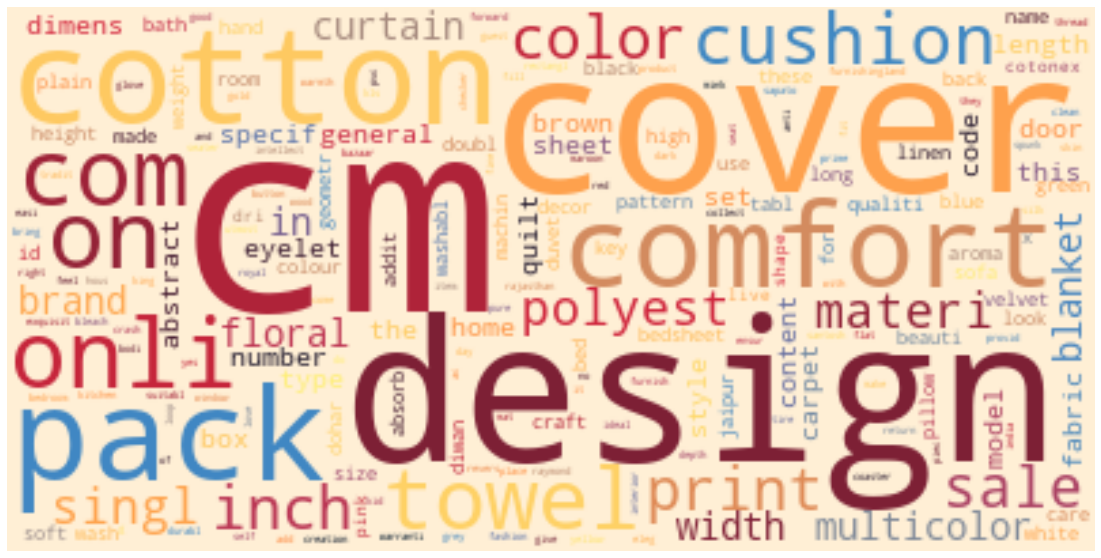

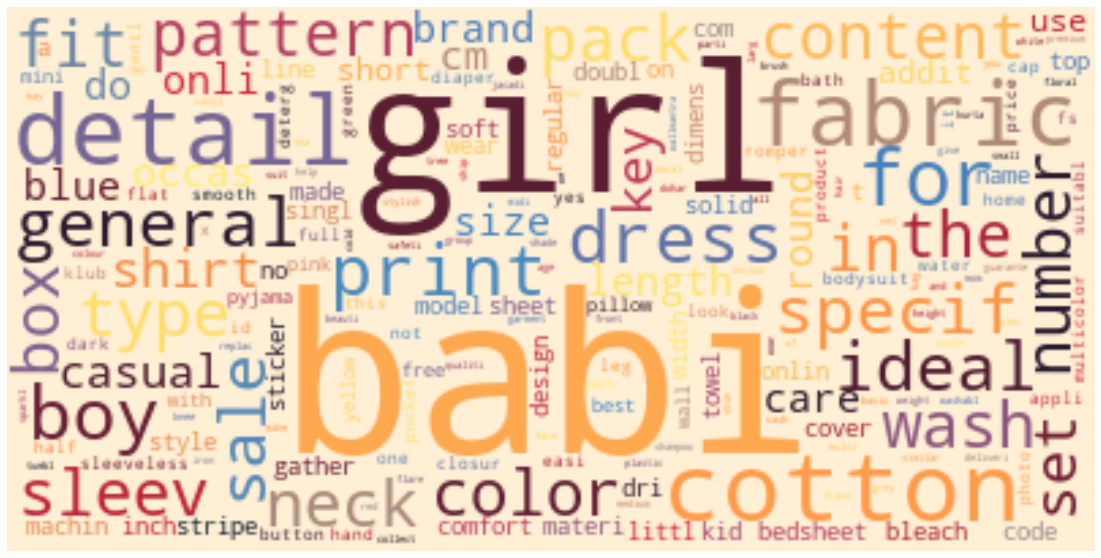

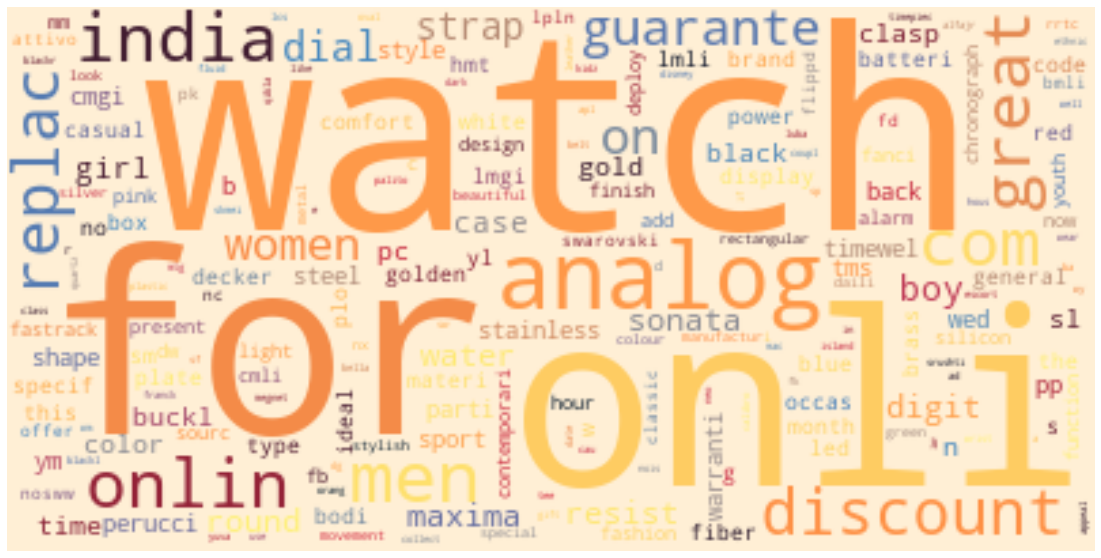

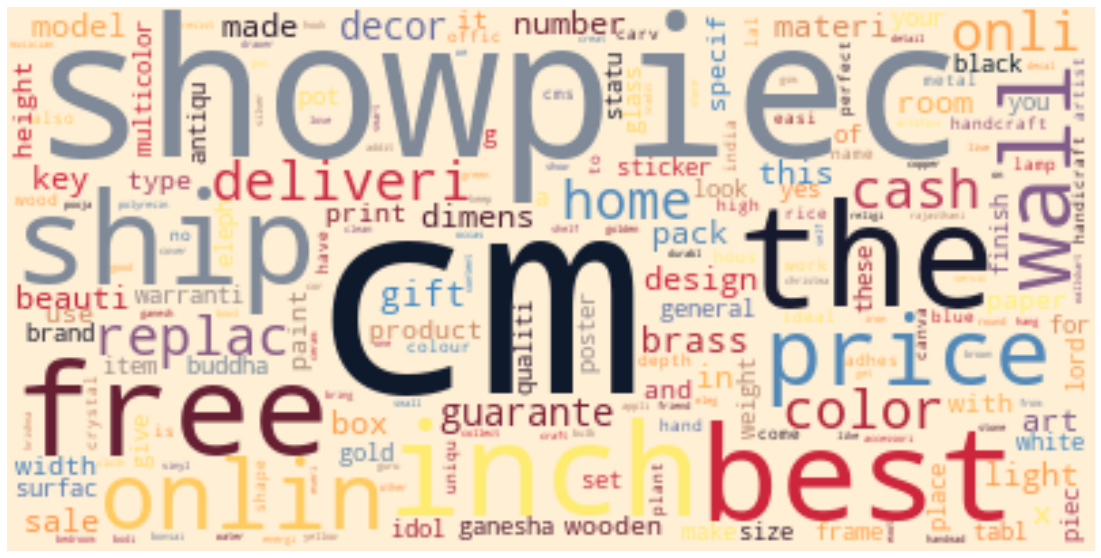

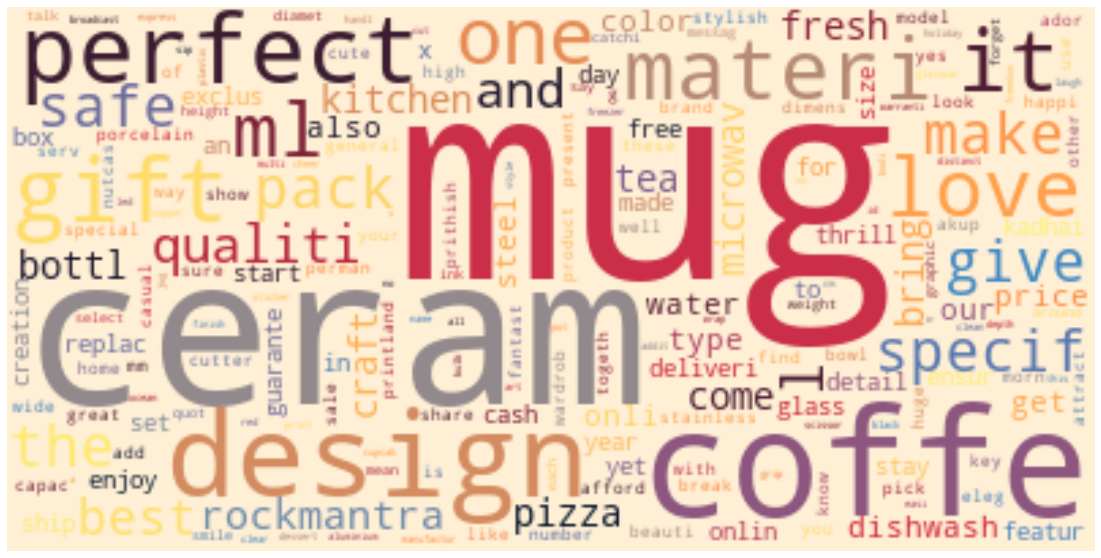

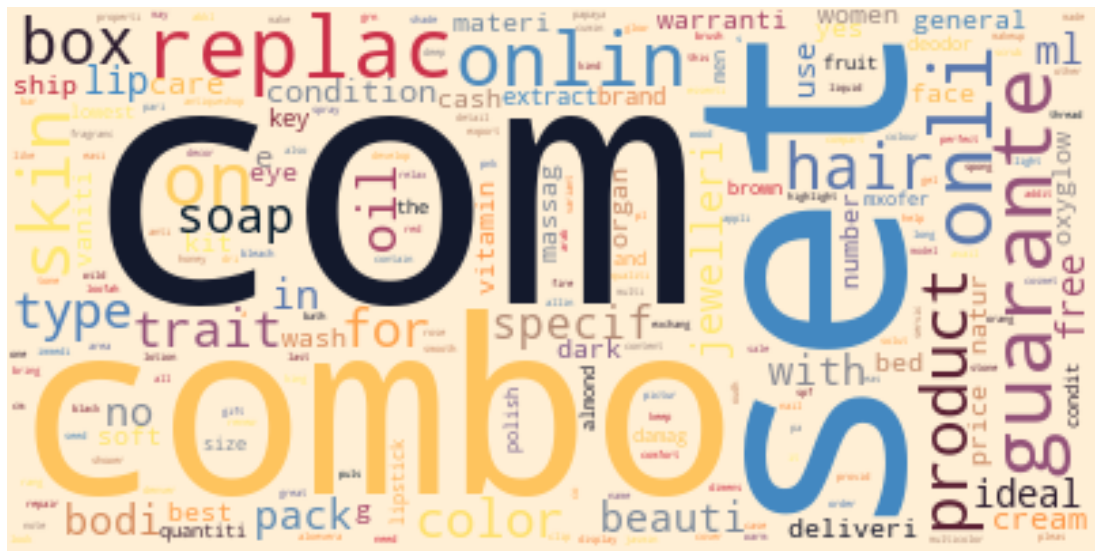

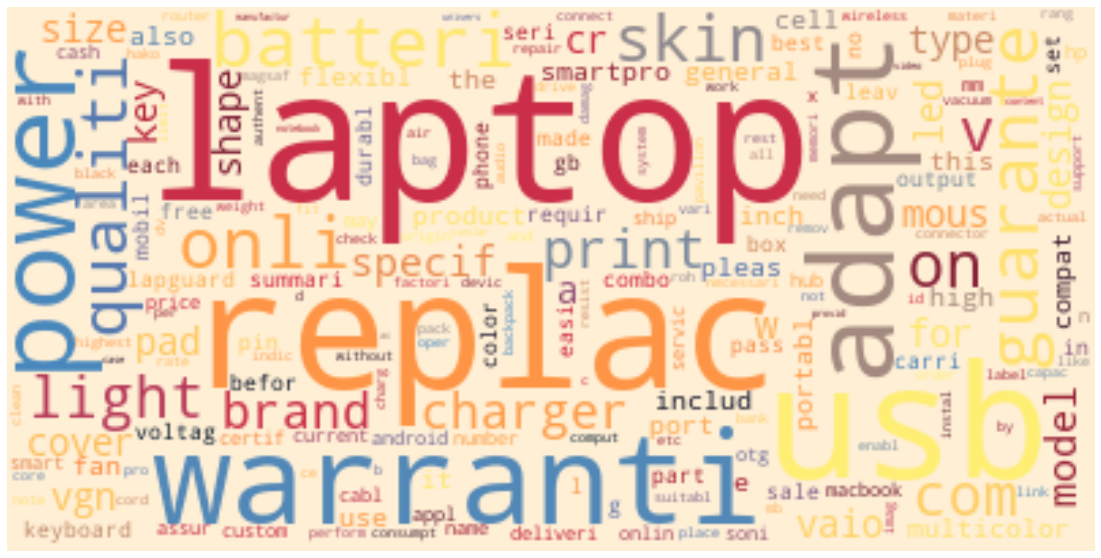

In [52]:
l = im['target'].unique()
for  i in l:
    m = hero.visualization.wordcloud(im[im['target'] == i]['description_cleaned_bis']), print('',i)
    m

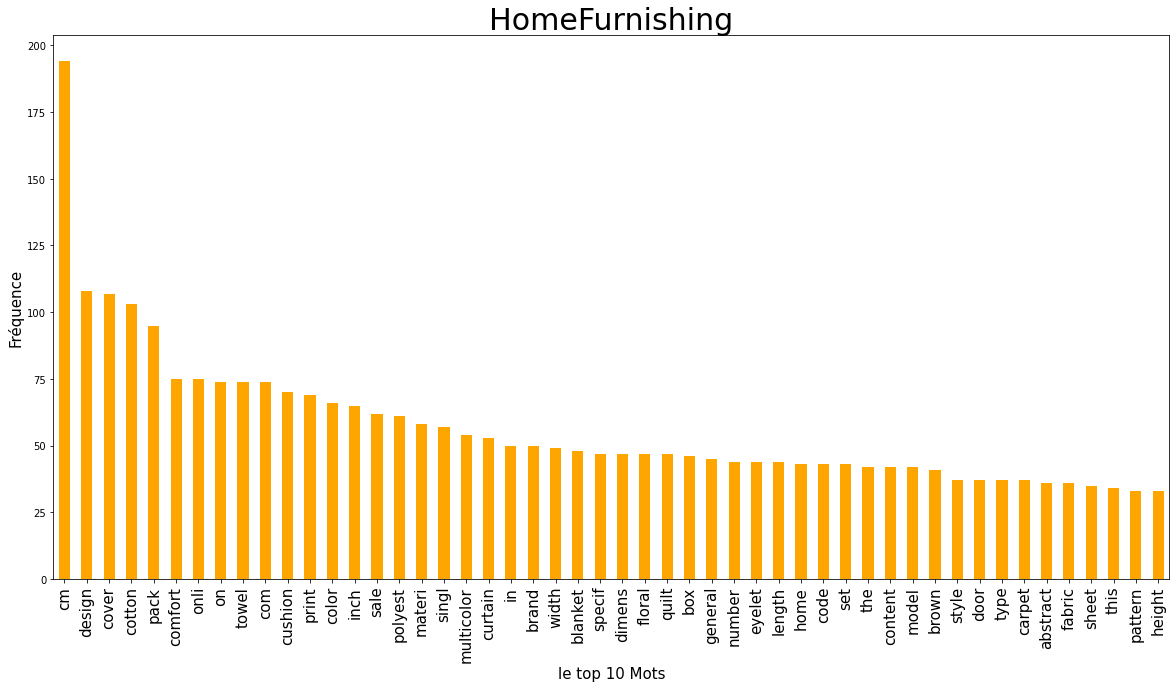

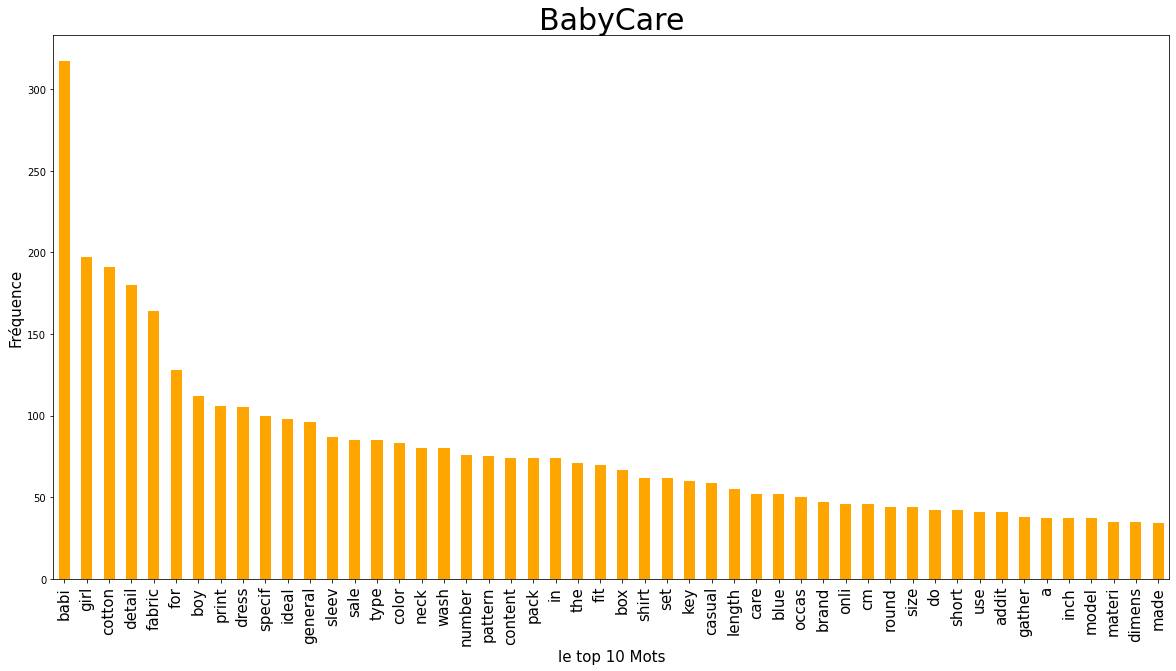

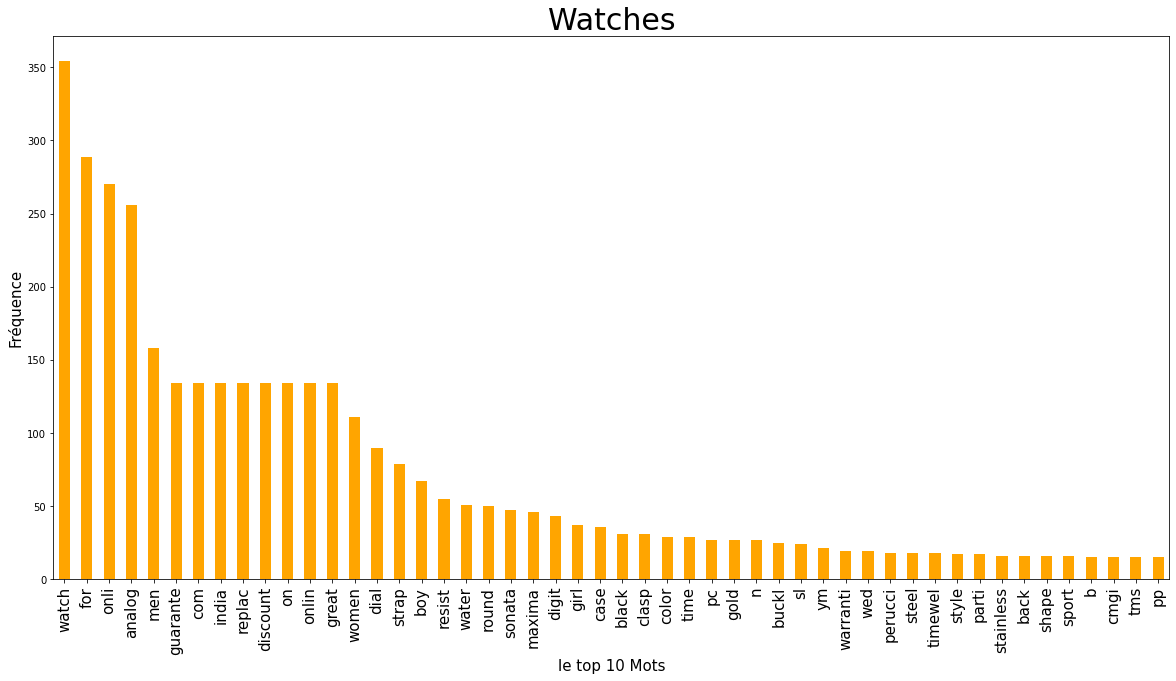

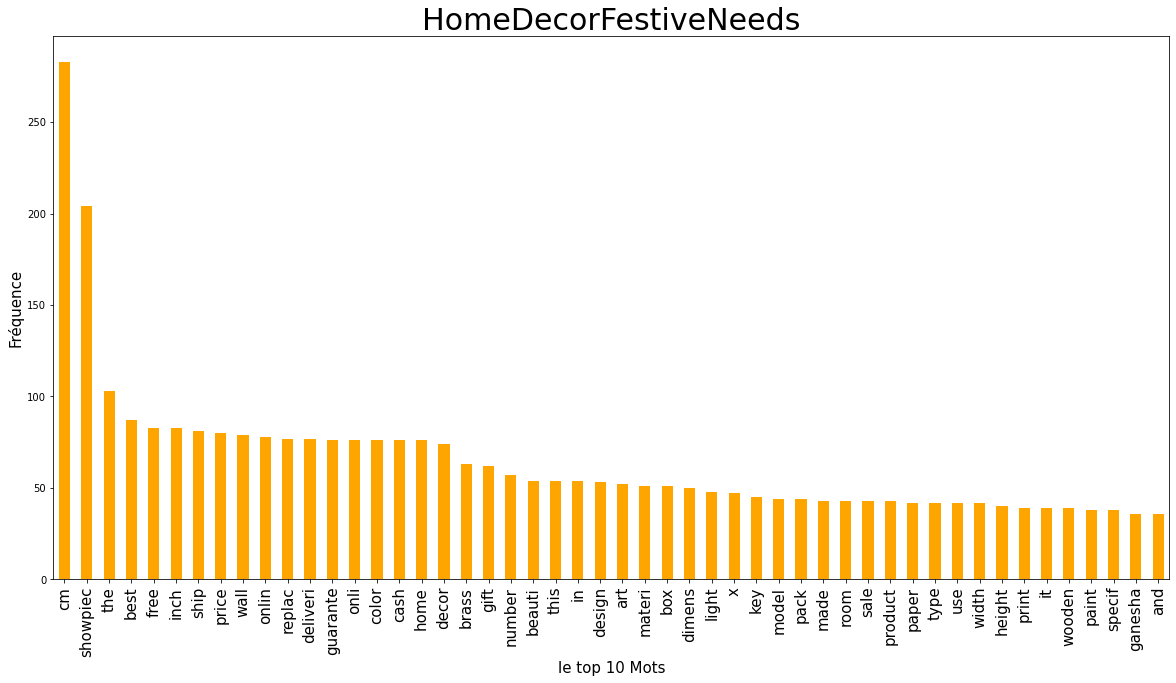

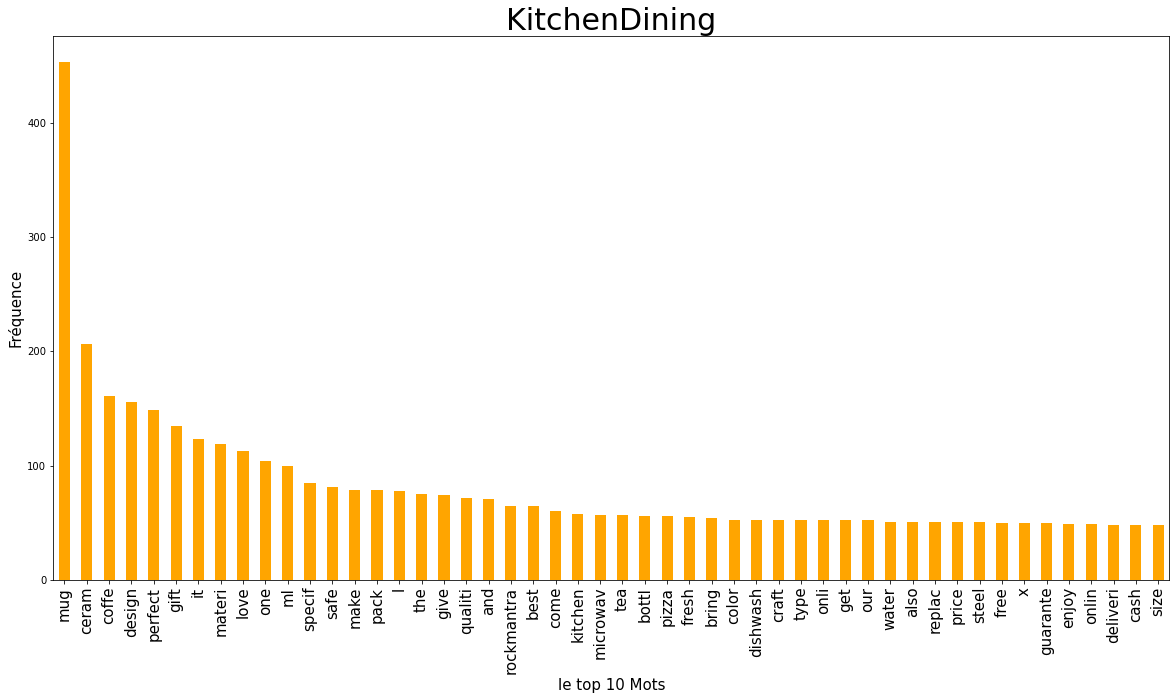

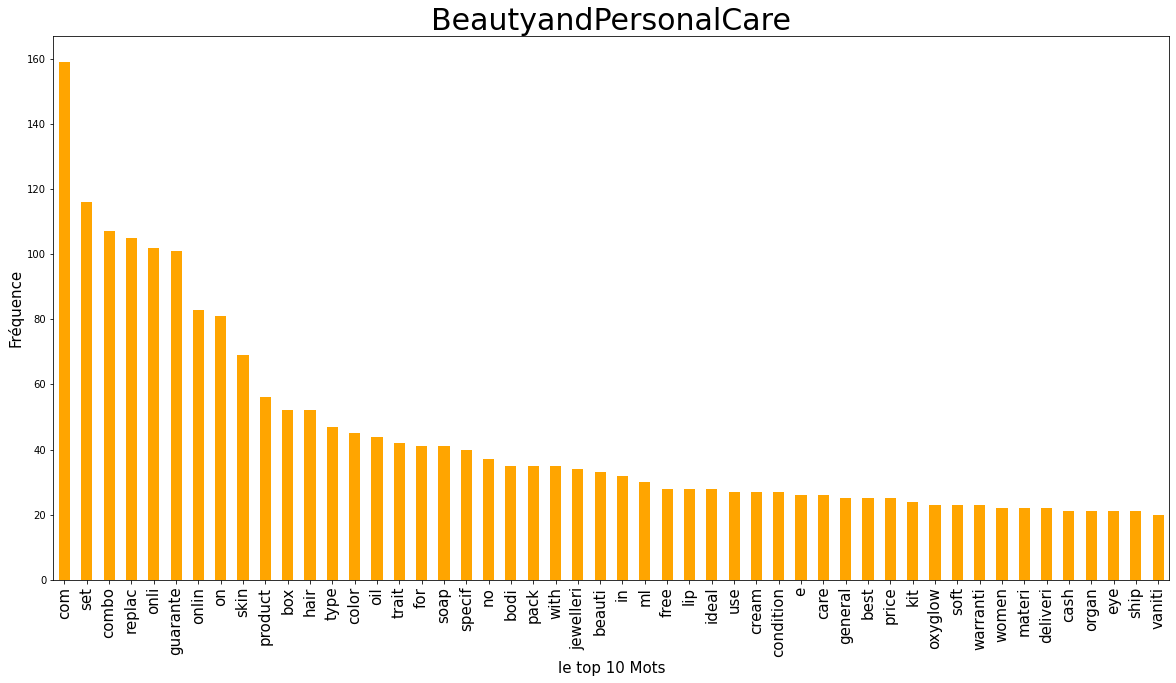

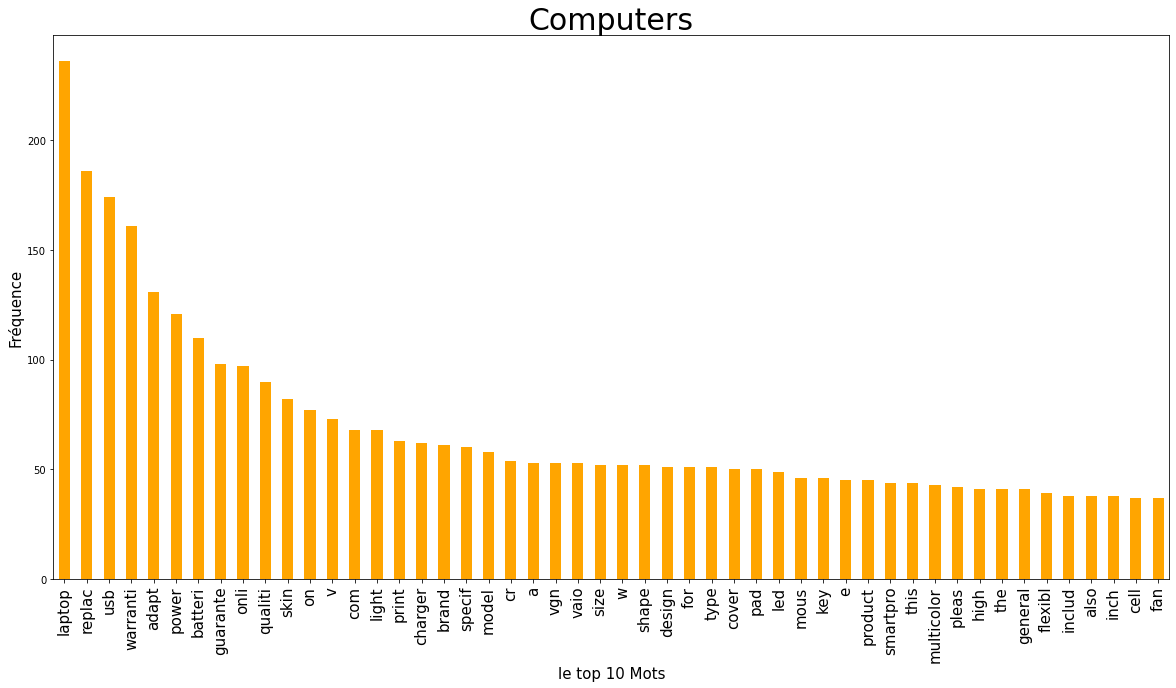

In [54]:
NUM_TOP_WORDS = 50
l = im['target'].unique()
for  i in l:
    p = hero.visualization.top_words(im[im['target'] == i]['description_cleaned_bis']).head(NUM_TOP_WORDS)
    plt.figure(figsize = (20,10))
    p.plot.bar(rot=90,color = 'orange');
    plt.title(i, fontsize=30)
    plt.ylabel('Fréquence', fontsize=15)
    plt.xlabel('le top 10 Mots',fontsize=15)
    plt.xticks(fontsize=15)
    plt.show(block=True);

#### Preprocessing avec la méthode lemmatisation 

In [55]:
lemmatizer = WordNetLemmatizer()

In [56]:
im['description_cleaned_lem'] = im['description'].apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in re.sub("[^a-zA-Z]"," ",x).split() if i not in words]).lower())

In [57]:
im[['description','description_cleaned_lem','target']]

description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                description_cleaned_lem          target  
0     key elegance polyester multicolor abstract eye...  HomeFurnishing  
1     specifications sathiyas cotton bath towel bath...        BabyCare  
2     key eurospa cotton terry face towel set size s...        BabyCare  
3     key santosh royal fashion cotton printed king ...  HomeFurnishing  
4     key jaipur print cotton floral king sized doub...  HomeFurnishing  
...                                                 ...             ...  
1045  oren empower extra large self adhesive sticker...        BabyCare  
1046  wallmantra large vinyl sticker sticker pack br...        BabyCare  
1047  uberlyfe extra large pigmented polyvinyl films...        BabyCare  
1048  wallmantra medium vinyl sticker sticker online...        BabyCare  
1049  uberlyfe large vinyl sticker online uberlyfe l...        BabyCare  

[1050 rows x 3 columns]

In [58]:
NUM_TOP_WORDS = 10
top_10 = hero.visualization.top_words(im['description_cleaned_lem']).head(NUM_TOP_WORDS)
top_10

only           718
for            611
cm             594
replacement    559
com            473
guarantee      471
on             429
mug            406
online         396
the            354
Name: description_cleaned_lem, dtype: int64

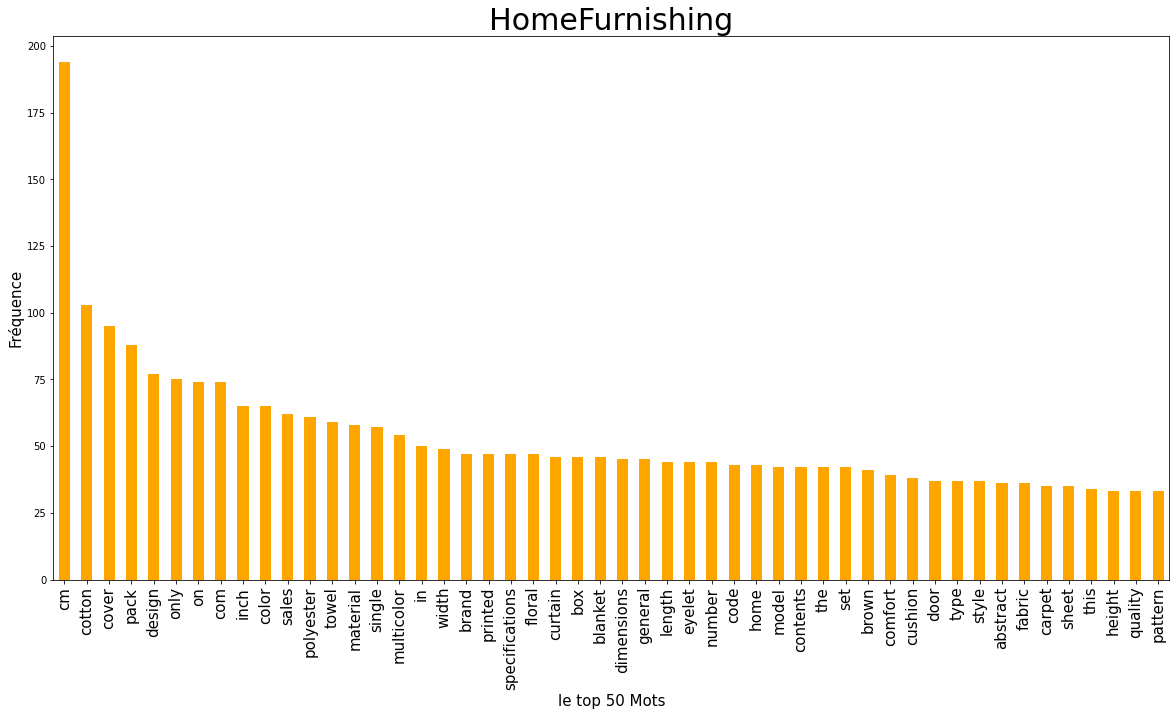

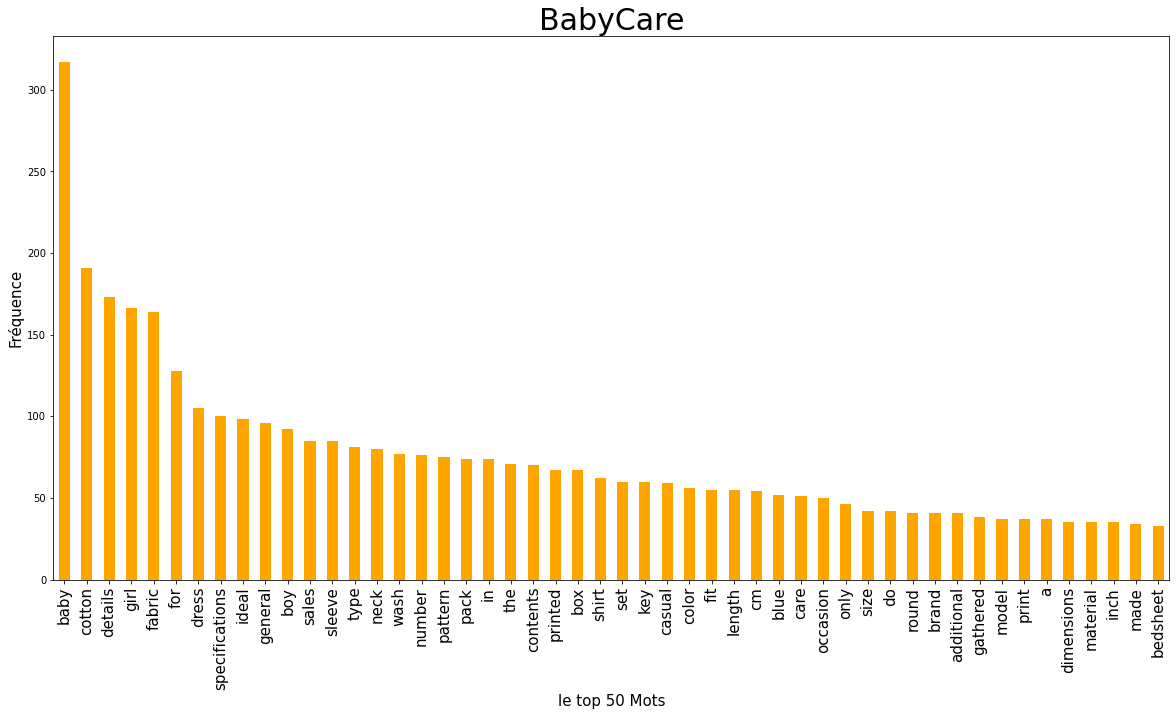

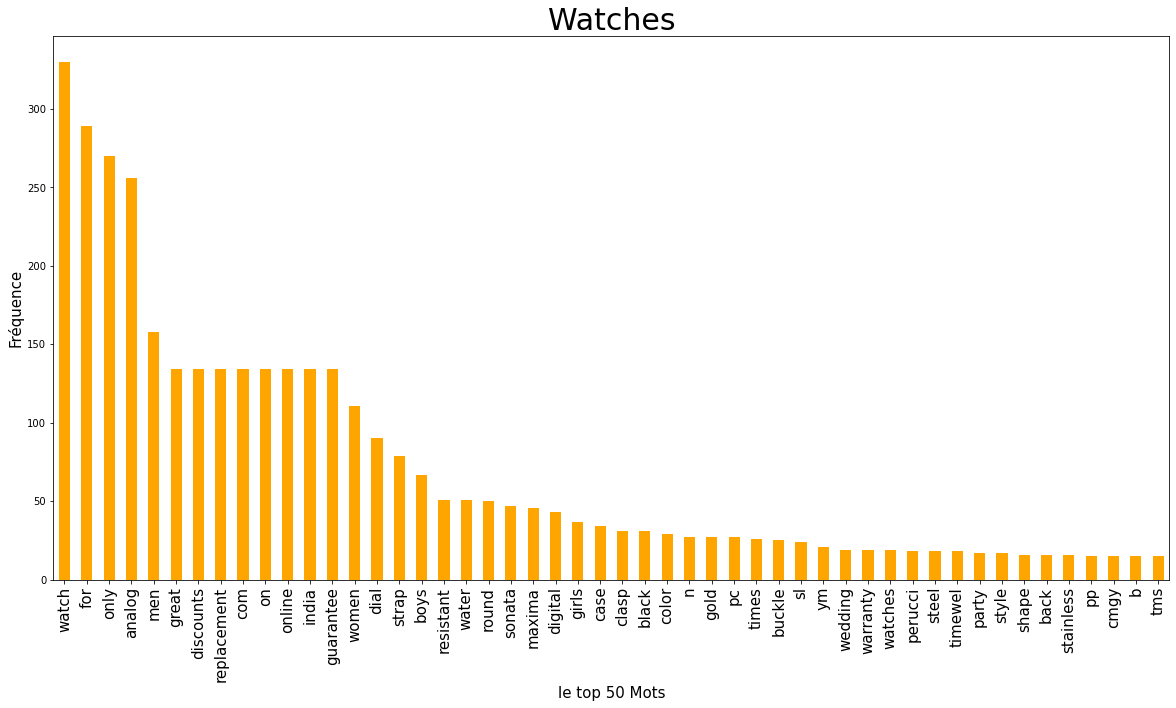

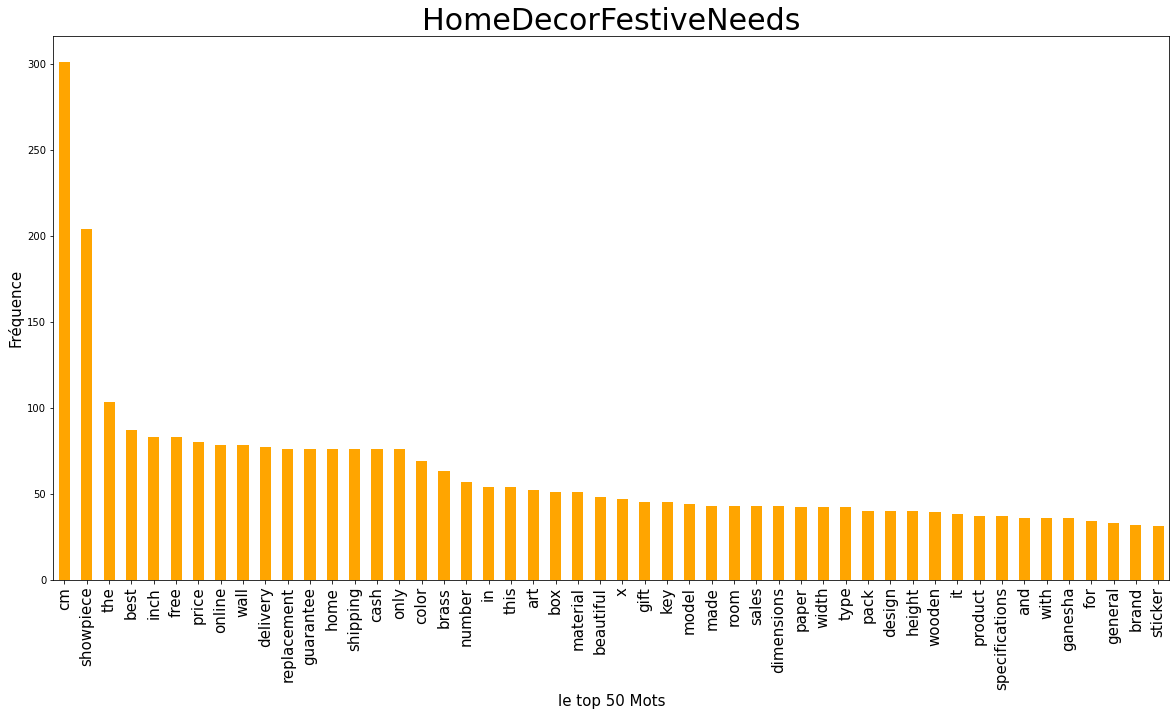

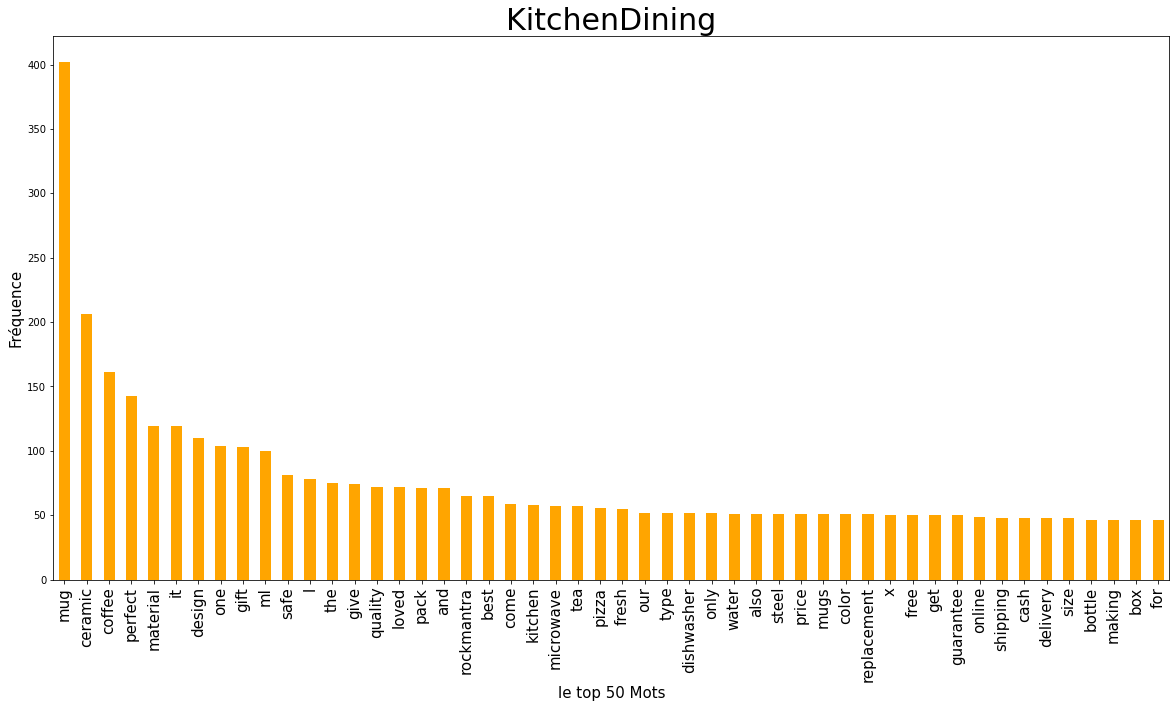

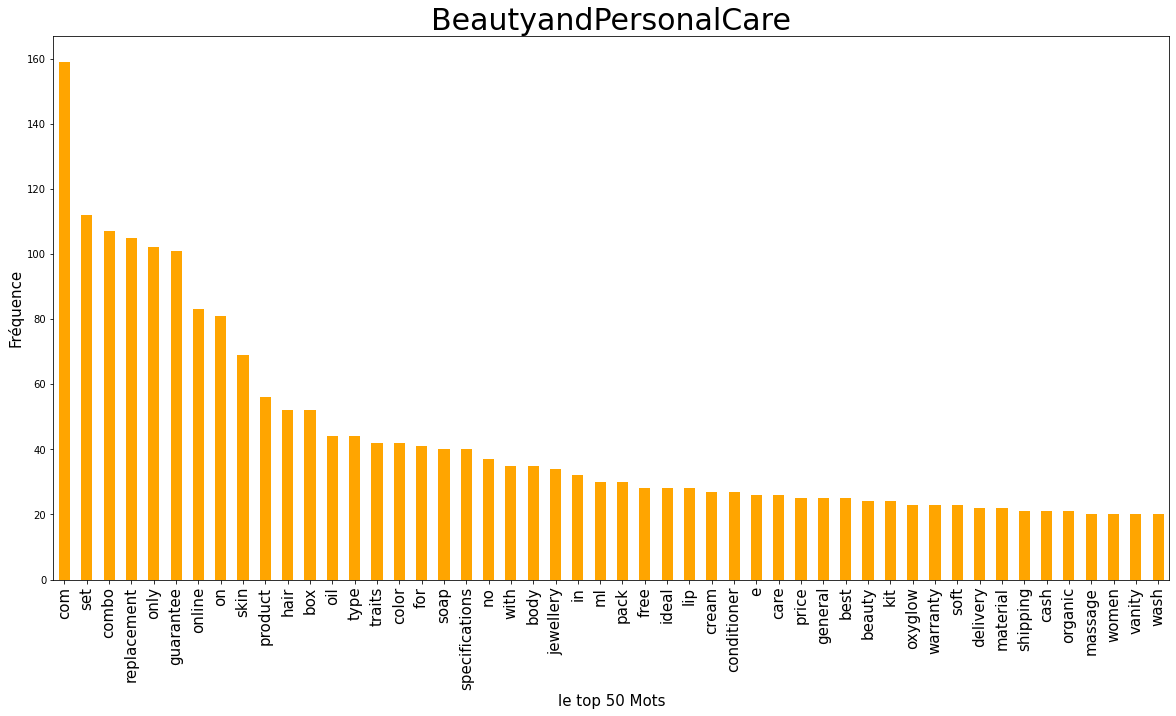

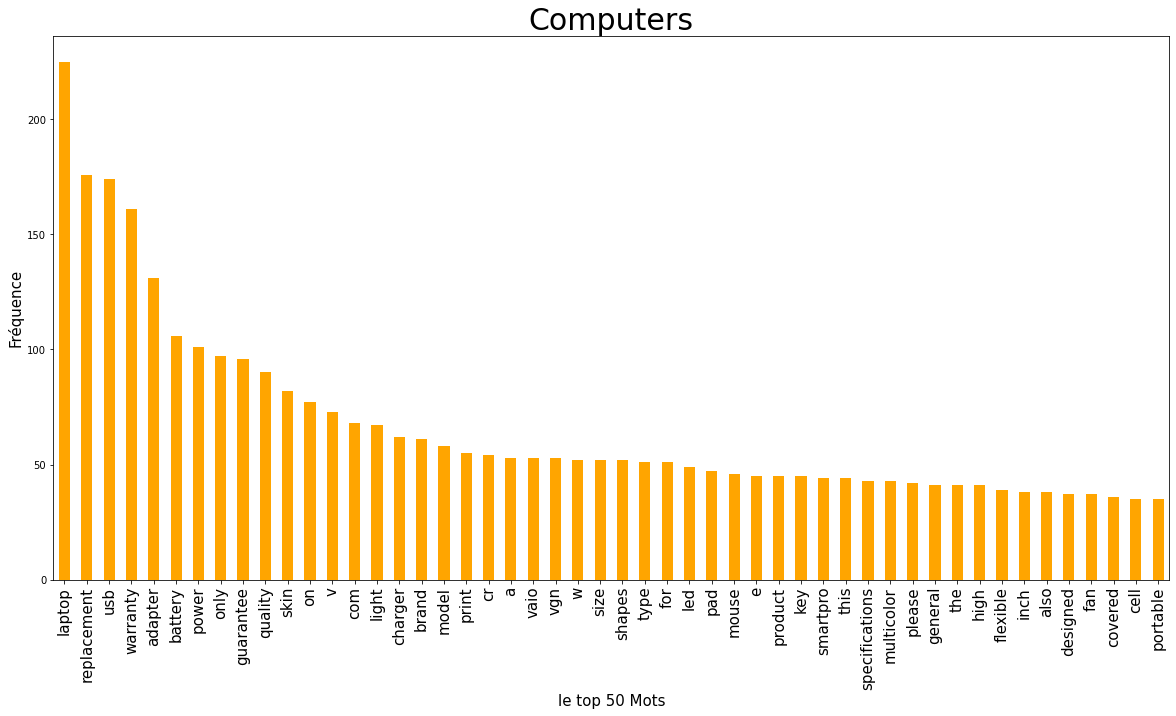

In [60]:
NUM_TOP_WORDS = 50
l = im['target'].unique()
for  i in l:
    p = hero.visualization.top_words(im[im['target'] == i]['description_cleaned_lem']).head(NUM_TOP_WORDS)
    plt.figure(figsize = (20,10))
    p.plot.bar(rot=90,color = 'orange');
    plt.title(i, fontsize=30)
    plt.ylabel('Fréquence', fontsize=15)
    plt.xlabel('le top 50 Mots',fontsize=15)
    plt.xticks(fontsize=15)
    plt.show(block=True);

In [61]:
im.to_csv('im1.csv')

### Méthode word embedding sur le jeu de donnée non nettoyé

Je vais utiliser le framework sentence transformers pour appliquer la méthode du word embedding ou plongement de mots en français. Ce framework s'applique a des textes mais aussi des images.

Il s’agit d’un Réseau de Neurone Récursif (Recurrent Neural Network) qui va rassembler les mots par rapport à leur « sens » dans un corps de texte. Le réseau de neurones de type ‘Word Embeddings’ va analyser chaque mot en fonction du ou des mots qui le précèdent.

Ce réseau de neurones va progressivement construire des liens entre les mots possédant des caractéristiques communes comme le sens ou l’entité d’un mot (nom commun, verbes, …).

Ces rassemblements de mots peuvent être vus comme des catégories de mots, mais parfois ils peuvent n’avoir aucun sens pour un être humain. Un mot ne sera donc plus représenté par un vecteur unitaire [0,0,0,1, …,0] d’un vocabulaire défini, mais par un pourcentage d’appartenance aux « classes » qui auront été créées par le réseau de neurones.

In [62]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [63]:
embeddings0 = model.encode(im['description'])

In [64]:
df_emb0 = pd.DataFrame(embeddings0)
df_emb0.to_csv('emb0.csv',index=False)

### Méthode word embedding sur le jeu de donnée nettoyé et la méthode de stemming

In [65]:
embeddings1 = model.encode(im['description_cleaned_bis'])

In [66]:
df_emb1 = pd.DataFrame(embeddings1)
df_emb1.to_csv('emb1.csv',index=False)

### Méthode word embedding sur le jeu de donnée nettoyé et la méthode de lemmatisation

In [67]:
embeddings2 = model.encode(im['description_cleaned_lem'])

In [68]:
df_emb2 = pd.DataFrame(embeddings2)
df_emb2.to_csv('emb2.csv',index=False)